# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas as pd
from KalmanFilters import EKF

# Testfall

$$\mathbf x = \begin{bmatrix}\mathtt{x} \\\mathtt{y} \\\mathtt{velocity}\\ \mathtt{angle} \\ \mathtt{angle per second}\end{bmatrix}=    \begin{bmatrix}x \\ y \\ v \\ \theta \\ \dot{\theta}\end{bmatrix}$$

In [2]:
dt = .04
dim_x = 5
init_state = np.array([0, 0, .0, 0, 0]) #x_pos, y_pos, v, theta, theta_dot

$$\dot{x} = v \cos(\theta)$$
$$\dot{y} = v \sin(\theta)$$
$$\dot{v} = 0$$
$$\dot{\theta} = \dot{\theta}$$
$$\ddot{\theta} = 0$$

$$
\Phi = \begin{bmatrix}
1 & 0 & cos(\theta)\Delta t & -vsin(\theta)\Delta t & 0 \\
0 & 1 & sin(\theta)\Delta t & vcos(\theta)\Delta t & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

In [3]:
def f(x, u):
    prior = np.empty_like(x)

    x_pos = x[0]
    y_pos = x[1]
    v = x[2]
    theta = x[3]
    omega = x[4]

    prior[0] = x_pos + v * np.cos(theta) * f.dt
    prior[1] = y_pos + v * np.sin(theta) * f.dt
    prior[2] = v
    prior[3] = theta + omega * f.dt
    prior[4] = omega

    return prior
f.dt = dt

In [4]:
def F_Jacobian(x):
    v = x[2]
    theta = x[3]

    F = np.eye(dim_x)
    F[:2, 2:4] = np.array([[np.cos(theta)*F_Jacobian.dt, -v*np.sin(theta)*F_Jacobian.dt],
                           [np.sin(theta)*F_Jacobian.dt, v*np.cos(theta)*F_Jacobian.dt]])

    F[3, 4] = F_Jacobian.dt
    return F
F_Jacobian.dt = dt

In [5]:
Q = np.eye(dim_x)
Q[:2,:2] = Q[:2,:2] * dt
Q[3,3] = dt

init_cov_matrix = np.array([.1**2,      0,      0,      0,      0,
                                    .1**2,      0,      0,      0,
                                             .5**2,      0,      0,
                                                     .5**2,      0,
                                                             .1**2])

$$
z = \begin{bmatrix}
heading_{gyro} \\
heading_{magneto} \\
heading_{odometry} \\
heading_{vision} \\
x_{odometry} \\
y_{odometry} \\
x_{vision} \\
y_{vision} \\
x_{efference} \\
y_{efference} \\
\end{bmatrix}
$$

In [6]:
dim_z = 10

$$
h(\mathbf x) = 
\begin{cases} 
\frac{180}{\pi} \theta \\
\frac{180}{\pi} \theta \\
\frac{180}{\pi} \theta \\
\frac{180}{\pi} \theta \\
x \\
y \\
x \\
y \\
x \\
y \\
\end{cases}
$$

In [7]:
def h(x):
    x_pos = x[0]
    y_pos = x[1]
    theta = x[3]
    theta_degrees = theta * (180 / np.pi)
    return np.array([theta_degrees, theta_degrees, theta_degrees, theta_degrees, x_pos, y_pos, x_pos, y_pos, x_pos, y_pos]).reshape((dim_z,))

$$
H = \begin{bmatrix}
0 & 0 & 0 & \frac{180}{\pi} & 0\\
0 & 0 & 0 & \frac{180}{\pi} & 0\\
0 & 0 & 0 & \frac{180}{\pi} & 0\\
0 & 0 & 0 & \frac{180}{\pi} & 0\\
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
\end{bmatrix}
$$

In [8]:
def H_Jacobian(x):
    H = np.zeros((dim_z, dim_x))
    H[:4, 3] = np.ones((4,)) * (180 / np.pi)
    for i in range(3):
        H[4+2*i, 0] = 1
        H[5+2*i, 1] = 1
    return H

$$
R = \begin{bmatrix}
\sigma_{heading_{gyro}}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & \sigma_{heading_{magneto}}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_{heading_{odometry}}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_{heading_{vision}}^2 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_{x_{odometry}}^2 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_{y_{odometry}}^2 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \sigma_{x_{vision}}^2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{y_{vision}}^2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{x_{efference}}^2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{y_{efference}}^2 \\
\end{bmatrix}
$$

In [9]:
heading_gyro_std = 1.
heading_magneto_std =1.
heading_odometry_std = 1.
heading_vision_std = 1.
x_odometry_std = .1
y_odometry_std = .1
x_vision_std = .1
y_vision_std = .1
x_efference_std = .1
y_efference_std = .1
R = np.diag([heading_gyro_std**2, heading_magneto_std**2, heading_odometry_std**2, heading_vision_std**2, 
             x_odometry_std**2, y_odometry_std**2, x_vision_std**2, y_vision_std**2, x_efference_std**2, y_efference_std**2])

# Messwerte

In [2]:
df_heading = pd.read_csv('./heading_data.csv')
df_position = pd.read_csv('./position_data.csv')
df = pd.merge(df_heading, df_position, left_index=True, right_index=True)
df.sample()

,head_gyro,head_magneto,head_odometry,head_vision,x_odometry,y_odometry,x_vision,y_vision,x_efference,y_efference
3695,261.201146,283.73,270.658537,268.366078,0.900561,-0.286476,0.883719,-0.349759,0.921228,-0.255083


In [11]:
zs = df.to_numpy()

# Klassisch

In [12]:
x = np.copy(init_state)
P = np.array([[.1**2,      0,     0,      0,      0],
              [     0, .1**2,     0,      0,      0],
              [     0,      0, .5**2,      0,      0],
              [     0,      0,     0, .5**2,      0],
              [     0,      0,     0,      0, .1**2]])

xs, cov = [], []

for z in zs:
    F = F_Jacobian(x)

    x = f(x, None)
    P = F @ P @ F.T + Q

    H = H_Jacobian(x)
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    y = np.subtract(z, h(x))
    x += K @ y
    I_KH = np.eye(dim_x) - K @ H
    P = I_KH @ P @ I_KH.T + K @ R @ K.T

    xs.append(x)
    cov.append(P)

xs = np.asarray(xs)
cov = np.asarray(cov)

(-1.0, 1.0)

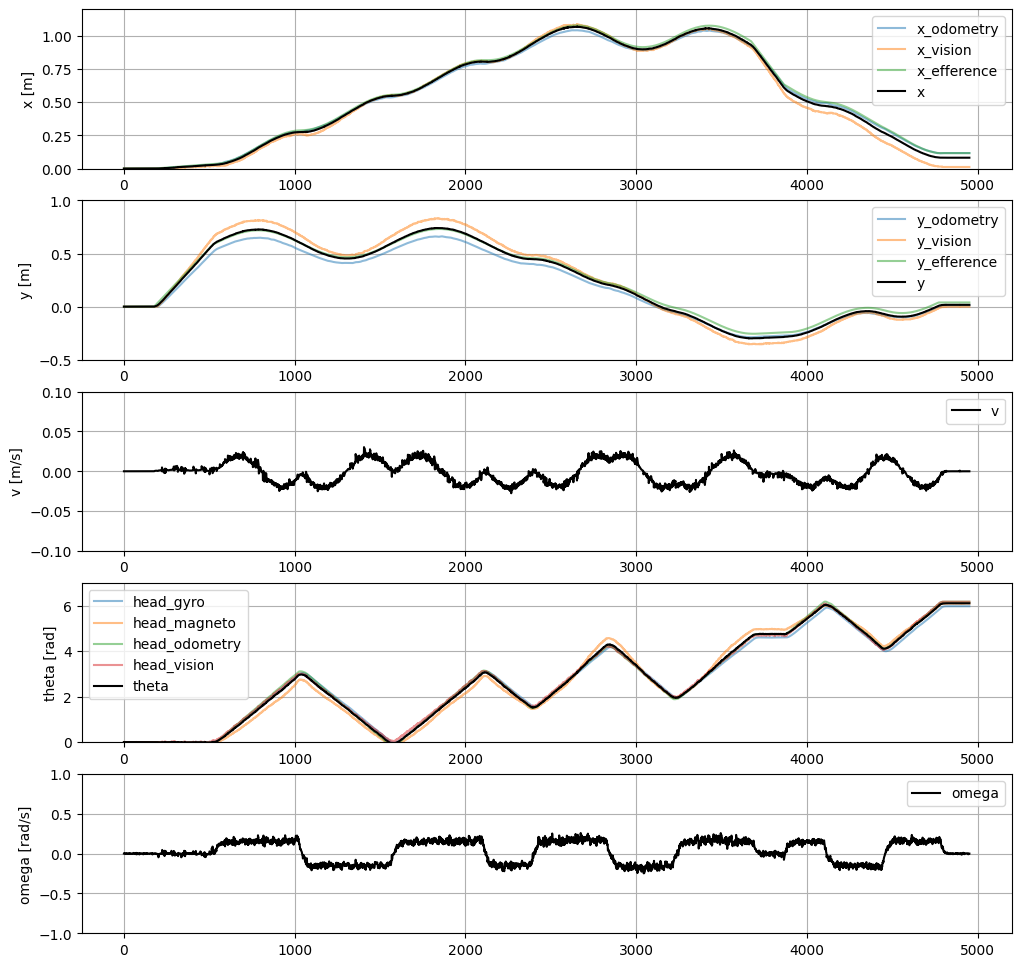

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(df['x_odometry'], label='x_odometry', alpha=.5)
plt.plot(df['x_vision'], label='x_vision', alpha=.5)
plt.plot(df['x_efference'], label='x_efference', alpha=.5)
plt.plot(xs[:, 0], c="black", label="x")
plt.ylabel("x [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 1.2)

plt.subplot(5, 1, 2)
plt.plot(df['y_odometry'], label='y_odometry', alpha=.5)
plt.plot(df['y_vision'], label='y_vision', alpha=.5)
plt.plot(df['y_efference'], label='y_efference', alpha=.5)
plt.plot(xs[:, 1], c="black", label="y")
plt.ylabel("y [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.5, 1)

plt.subplot(5, 1, 3)
plt.plot(xs[:, 2], c="black", label="v")
plt.ylabel("v [m/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.1, .1)

plt.subplot(5, 1, 4)
plt.plot(df['head_gyro'] * np.pi / 180, label='head_gyro', alpha=.5)
plt.plot(df['head_magneto'] * np.pi / 180, label='head_magneto', alpha=.5)
plt.plot(df['head_odometry'] * np.pi / 180, label='head_odometry', alpha=.5)
plt.plot(df['head_vision'] * np.pi / 180, label='head_vision', alpha=.5)
plt.plot(xs[:, 3], c="black", label="theta")
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 7)

plt.subplot(5, 1, 5)
plt.plot(xs[:, 4], c="black", label="omega")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 1)

(-0.5, 1.0)

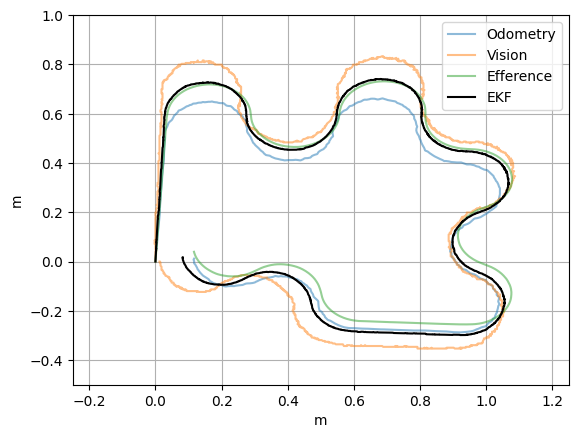

In [14]:
plt.subplot(1, 1, 1)
plt.plot(df['x_odometry'], df['y_odometry'], label="Odometry", alpha=.5)
plt.plot(df['x_vision'], df['y_vision'], label="Vision", alpha=.5)
plt.plot(df['x_efference'], df['y_efference'], label="Efference", alpha=.5)
plt.plot(xs[:, 0], xs[:, 1], c="black", label="EKF")
plt.xlabel("m")
plt.ylabel("m")
plt.grid()
plt.legend(loc="best")
plt.xlim(-.25, 1.25)
plt.ylim(-.5, 1)

(0.0, 0.02)

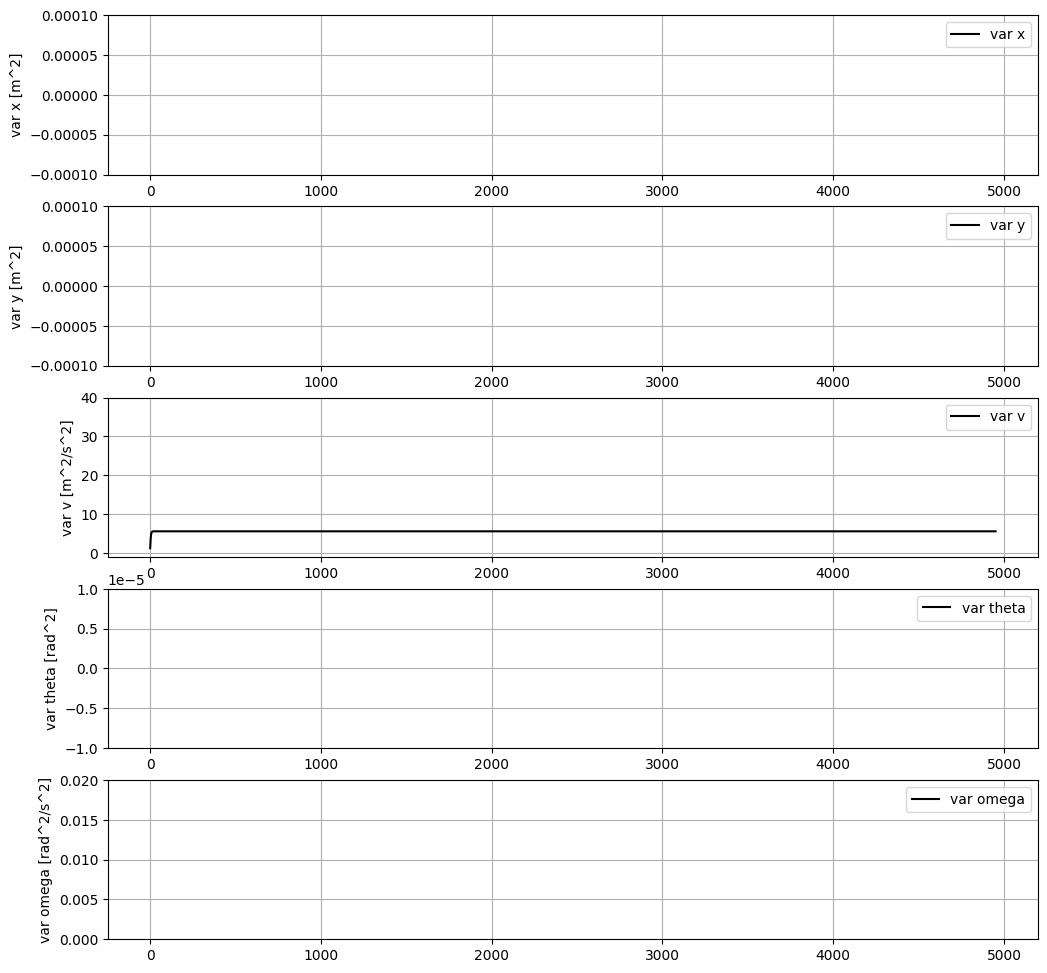

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(cov[:, 0, 0], c="black", label="var x")
plt.ylabel("var x [m^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.0001, .0001)

plt.subplot(5, 1, 2)
plt.plot(cov[:, 1, 1], c="black", label="var y")
plt.ylabel("var y [m^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.0001, .0001)

plt.subplot(5, 1, 3)
plt.plot(cov[:, 2, 2], c="black", label="var v")
plt.ylabel("var v [m^2/s^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 40)

plt.subplot(5, 1, 4)
plt.plot(cov[:, 3, 3], c="black", label="var theta")
plt.ylabel("var theta [rad^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.00001, .00001)

plt.subplot(5, 1, 5)
plt.plot(cov[:, 4, 4], c="black", label="var omega")
plt.ylabel("var omega [rad^2/s^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, .02)

# Nengo

In [16]:
ekf = EKF(dim_x=dim_x, dim_z=dim_z, dt=dt, f=f, F_Jacobian=F_Jacobian, Q=Q, h=h, H_Jacobian=H_Jacobian, R=R)

In [17]:
ekf.initial_x = init_state
ekf.initial_P = init_cov_matrix
ekf.simulation_runtime= 200.
ekf.connection_synapse = .1
ekf.x_intercepts = nengo.dists.Uniform(-1.,1.)
ekf.x_max_rates = nengo.dists.Uniform(400,500)
ekf.x_radius = 7

In [18]:
probes = ekf.build_model_for_measurements(zs=zs).execute().get_probes()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nengo/node.py:62: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  warnings.warn(


Build finished in 0:00:01.                                                      
Simulation finished in 0:05:17.                                                 


(-0.5, 1.0)

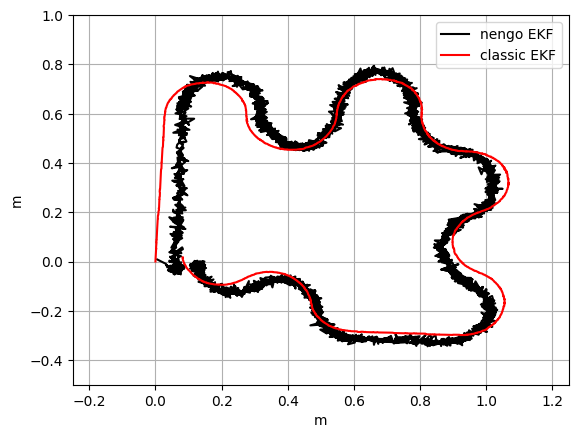

In [19]:
plt.subplot(1, 1, 1)
plt.plot(probes['x'].T[0], probes['x'].T[1], c="black", label="nengo EKF")
plt.plot(xs[:, 0], xs[:, 1], c="red", label="classic EKF")
#plt.plot(df['x_odometry'], df['y_odometry'], label="Odometry")
#plt.plot(df['x_vision'], df['y_vision'], label="Vision")
#plt.plot(df['x_efference'], df['y_efference'], label="Efference")
plt.xlabel("m")
plt.ylabel("m")
plt.grid()
plt.legend(loc="best")
plt.xlim(-.25, 1.25)
plt.ylim(-.5, 1)

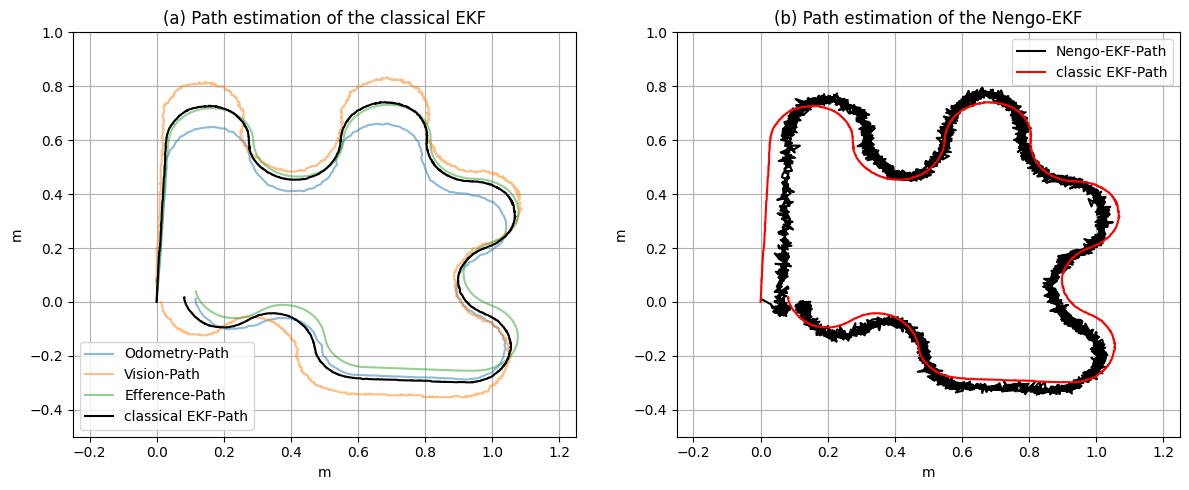

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('(a) Path estimation of the classical EKF')
plt.plot(df['x_odometry'], df['y_odometry'], label="Odometry-Path", alpha=.5)
plt.plot(df['x_vision'], df['y_vision'], label="Vision-Path", alpha=.5)
plt.plot(df['x_efference'], df['y_efference'], label="Efference-Path", alpha=.5)
plt.plot(xs[:, 0], xs[:, 1], c="black", label="classical EKF-Path")
plt.xlabel("m")
plt.ylabel("m")
plt.grid()
plt.legend(loc="best")
plt.xlim(-.25, 1.25)
plt.ylim(-.5, 1)

plt.subplot(1, 2, 2)
plt.title('(b) Path estimation of the Nengo-EKF')
plt.plot(probes['x'].T[0], probes['x'].T[1], c="black", label="Nengo-EKF-Path")
plt.plot(xs[:, 0], xs[:, 1], c="red", label="classic EKF-Path")
plt.xlabel("m")
plt.ylabel("m")
plt.grid()
plt.legend(loc="best")
plt.xlim(-.25, 1.25)
plt.ylim(-.5, 1)

plt.tight_layout()
plt.subplots_adjust(wspace=.2)
plt.show()

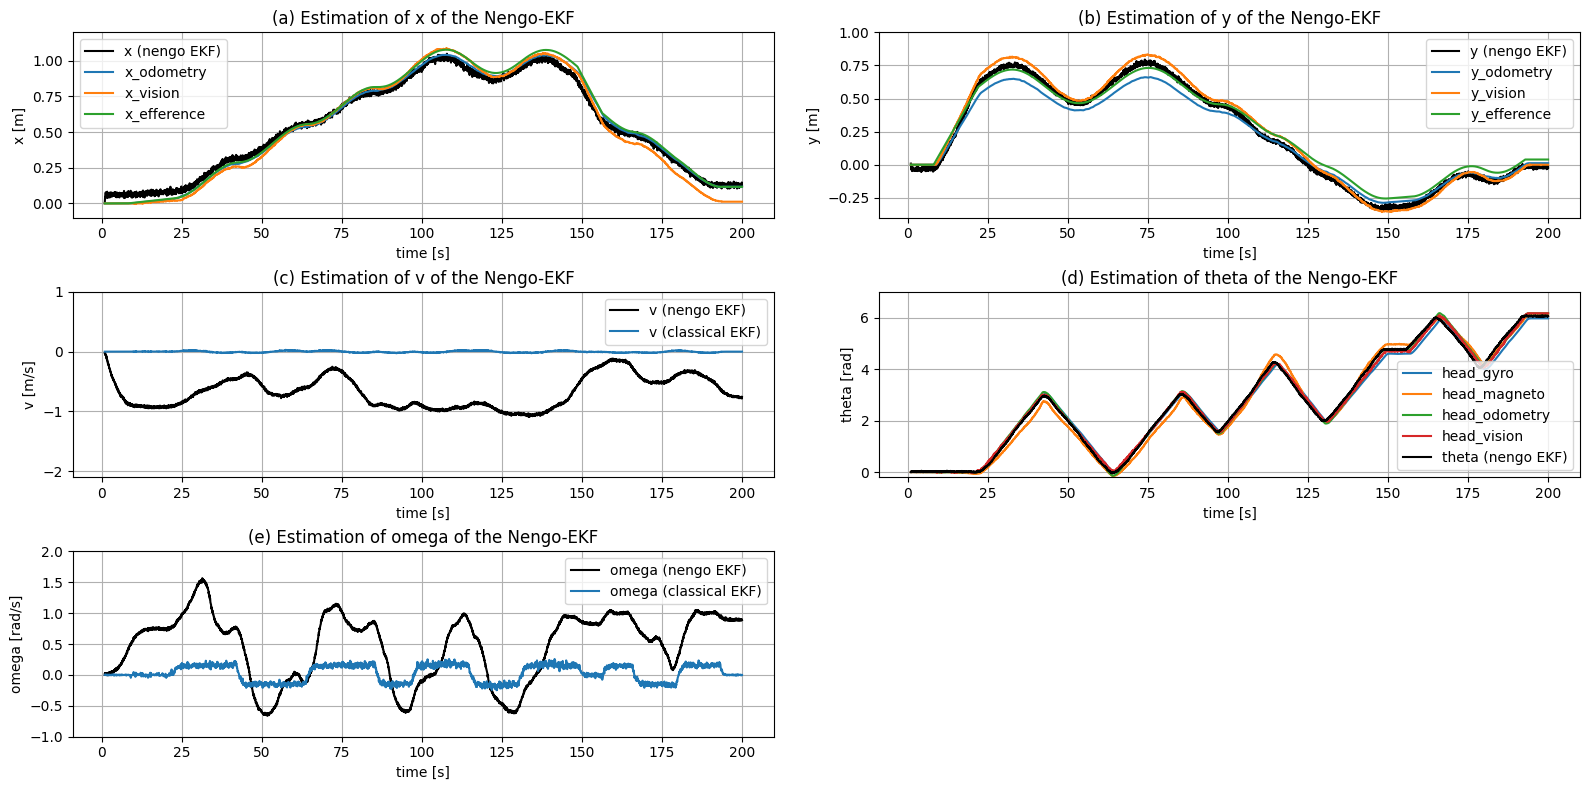

In [21]:
plt.figure(figsize=(16,8))

plt.subplot(3, 2, 1)
plt.title('(a) Estimation of x of the Nengo-EKF')
plt.plot(np.linspace(1,200,5000), probes['x'].T[0], c="black", label="x (nengo EKF)")
plt.plot(np.linspace(1,200,4952), df['x_odometry'], label='x_odometry')
plt.plot(np.linspace(1,200,4952), df['x_vision'], label='x_vision')
plt.plot(np.linspace(1,200,4952), df['x_efference'], label='x_efference')
plt.xlabel("time [s]")
plt.ylabel("x [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.1, 1.2)

plt.subplot(3, 2, 2)
plt.title('(b) Estimation of y of the Nengo-EKF')
plt.plot(np.linspace(1,200,5000), probes['x'].T[1], c="black", label="y (nengo EKF)")
plt.plot(np.linspace(1,200,4952), df['y_odometry'], label='y_odometry')
plt.plot(np.linspace(1,200,4952), df['y_vision'], label='y_vision')
plt.plot(np.linspace(1,200,4952), df['y_efference'], label='y_efference')
plt.xlabel("time [s]")
plt.ylabel("y [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.4, 1)

plt.subplot(3, 2, 3)
plt.title('(c) Estimation of v of the Nengo-EKF')
plt.plot(np.linspace(1,200,5000), probes['x'].T[2], c="black", label="v (nengo EKF)")
plt.plot(np.linspace(1,200,4952), xs[:, 2], label="v (classical EKF)")
plt.xlabel("time [s]")
plt.ylabel("v [m/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-2.1, 1.)

plt.subplot(3, 2, 4)
plt.title('(d) Estimation of theta of the Nengo-EKF')
plt.plot(np.linspace(1,200,4952), df['head_gyro'] * np.pi / 180, label='head_gyro')
plt.plot(np.linspace(1,200,4952), df['head_magneto'] * np.pi / 180, label='head_magneto')
plt.plot(np.linspace(1,200,4952), df['head_odometry'] * np.pi / 180, label='head_odometry')
plt.plot(np.linspace(1,200,4952), df['head_vision'] * np.pi / 180, label='head_vision')
plt.plot(np.linspace(1,200,5000), probes['x'].T[3], c="black", label="theta (nengo EKF)")
plt.xlabel("time [s]")
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.2, 7)

plt.subplot(3, 2, 5)
plt.title('(e) Estimation of omega of the Nengo-EKF')
plt.plot(np.linspace(1,200,5000), probes['x'].T[4], c="black", label="omega (nengo EKF)")
plt.plot(np.linspace(1,200,4952), xs[:, 4], label="omega (classical EKF)")
plt.xlabel("time [s]")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 2)

plt.tight_layout()
plt.subplots_adjust(wspace=.15, hspace=.4)
plt.show()